In [1]:
import numpy as np 
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn import linear_model, datasets
from sklearn.metrics import confusion_matrix, classification_report, precision_score
import seaborn as sns

# Data Prepration

In [2]:

root=r"C:\Users\STEVE\Desktop\data\ebook exce\takehome exams"
path=os.path.join(root, 'conversion_data.csv')
df=pd.read_csv(path)
print(df.info())
for col in df.columns:
    print("number of unique values in column %s =  %d"%(col,(df[str(col)].nunique())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
None
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
number of unique values in column country =  4
number of unique values in column age =  60
number of unique values in column new_user =  2
number of unique values in column source =  3
number of unique values in column total_pages_visited =  29
number of unique values in column converted =  2


Conclusion 1) The number of entries is equal to the number of non-null values of each column, so there are no missing data

Conclusion 2) It seems that all the columns except age and total_oages_visisted are categorical data. I plot them to check the values and if the data is unbalanced


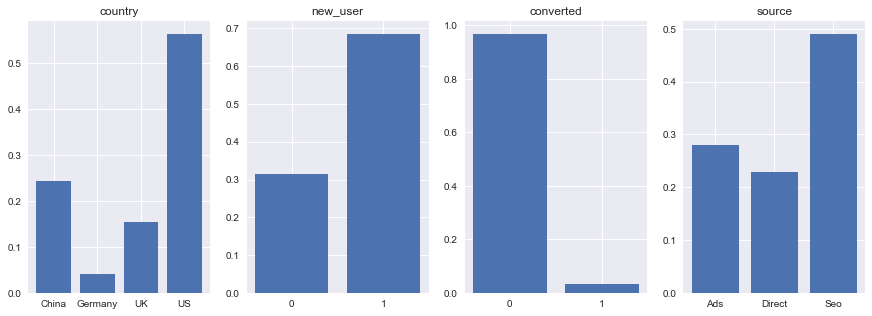

In [4]:
###look at the categirical data and their counts
fig = plt.figure(figsize=(15,5))
col_list=['country', 'new_user', 'converted', 'source']

for pos, col in enumerate(col_list):
    percent_summary=(df.groupby([str(col)]).count()/df[str(col)].count())
    category_num=len(percent_summary.index.tolist())
    a = fig.add_subplot(1, len(col_list), pos+1)
    a.set_title(str(col))
    plt.bar(np.arange(category_num), percent_summary.iloc[:,0])
    plt.xticks(np.arange(category_num),percent_summary.index)
plt.show()

#Conclusion 1: data looks OK and there is no type or non-sense label
#Conclusion 2: Column "converetd" is our data to predict; and it is not balanced
#next, I will check for continueous data to see if there are unreasonable values

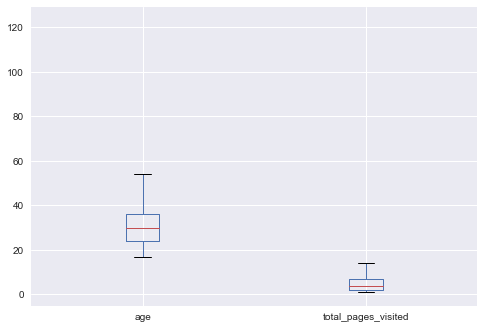

In [5]:
df[['age','total_pages_visited']].plot.box()
plt.show()

###there are two age.values greater than 100. I will remove them and then create dummy variables


In [6]:
df=df[df.age<90]
def create_dummy(df, col_list):
    dummies = pd.get_dummies(df[col_list])
    df_with_dummy=pd.concat((df,dummies),axis=1)
    df_with_dummy.drop(col_list, inplace=True, axis=1)
    return df_with_dummy
df_dummy=create_dummy(df, ['source', 'country'])
df_dummy.head(3)

,age,new_user,total_pages_visited,converted,source_Ads,source_Direct,source_Seo,country_China,country_Germany,country_UK,country_US
0,25,1,1,0,1,0,0,0,0,1,0
1,23,1,5,0,0,0,1,0,0,0,1
2,28,1,4,0,0,0,1,0,0,0,1


Creat test and train sets and X/Y matrixes

In [7]:
train, test=train_test_split(df_dummy, test_size=0.3,  random_state=11, stratify=df.converted)
X_train=train.loc[:,train.columns!='converted']
Y_train=train['converted']
X_test=test.loc[:,test.columns!='converted']
Y_test=test['converted']

Plot correlation between variables 

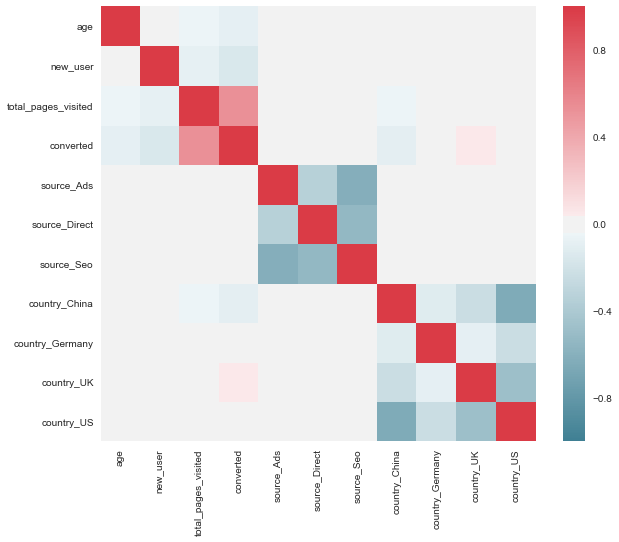

In [8]:
corr = train.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

The correlaation plot does not show strong correlation between non-dummy variables

# Feature Selection 

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
#########scale them to use logistic regression for the variable selection 
scaler = StandardScaler()
X_tr_std = scaler.fit_transform(X_train)



First method of variable selection: logistic regression 

In [11]:
estimator = linear_model.LogisticRegression(C=1e5, fit_intercept=True, class_weight='balanced')
selector = RFE(estimator, 1, step=1)
selector = selector.fit(X_tr_std, Y_train)
selector.ranking_

array([ 4,  3,  1, 10,  8,  9,  2,  7,  6,  5])

Second method of variable selection: random forest 

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

In [16]:
clf_rf = RandomForestClassifier(n_estimators=100, max_features=1,max_depth=3, random_state=11, 
                                oob_score=True, class_weight='balanced')
clf_rf=clf_rf.fit(X_train, Y_train)
print(clf_rf.feature_importances_)

[0.10490975 0.20496624 0.40179655 0.00161265 0.00298623 0.00075419
 0.1645449  0.02058203 0.06118982 0.03665764]


I create a data base showing the ranks based on the 2 methods and then will plot them 

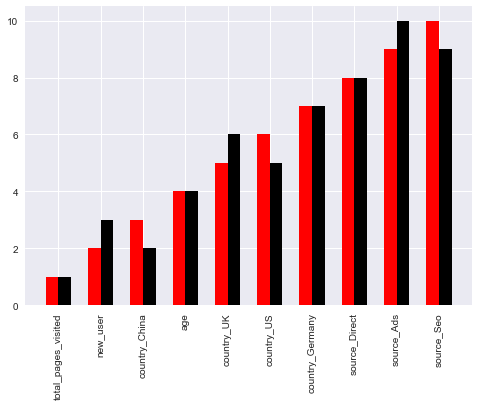

In [72]:
ranks=pd.DataFrame({ 'RF_importance':clf_rf.feature_importances_*100, 'LR_ranks':selector.ranking_}, index=X_train.columns)
ranks
ranks['RF_ranks']=ranks['RF_importance'].rank(ascending=False)

fig, ax=plt.subplots(1,1)
w=.3
plt.bar(ranks.RF_ranks+w/2, ranks.LR_ranks,  width=w,color='k')
plt.bar(ranks.RF_ranks-w/2, ranks.RF_ranks, width=w, color='r')
plt.xticks(ranks.RF_ranks, ranks.index, rotation=90)
plt.show()

This shows that the source is the least important variable, it can be eliminated. I China and UK show similar degree of correlation with 
converion as dispayed in the correlation plot. So I will choose the first 5 variables. 

In [79]:
selected_cols=ranks[ranks.RF_ranks<6].index
X_model=X_train[selected_cols]
Y_model=Y_train

In [107]:
lr = linear_model.LogisticRegression(C=1e5, fit_intercept=True, class_weight='balanced')
lr=lr.fit(X_model, Y_model)
lr.score(X_model, Y_model)

0.9406428177719145

In [110]:
##use cross validation to determie weight
from sklearn.model_selection import cross_val_score
def create_weights():
    Interval=np.arange(0.1,0.91,0.05)
    
    return Interval
weights=create_weights()
Scores=[]
for w in weights:
    logreg = linear_model.LogisticRegression(C=1e5, fit_intercept=True, class_weight={1:w, 0:(1-w)})
    Scores.append(cross_val_score(logreg, X_model, Y_model).mean())
    print(w,end="")
    

0.10.150000000000000020.200000000000000040.250000000000000060.300000000000000040.35000000000000010.400000000000000130.450000000000000070.50000000000000010.55000000000000020.60000000000000020.65000000000000010.70000000000000020.75000000000000020.80000000000000020.85000000000000020.9000000000000002

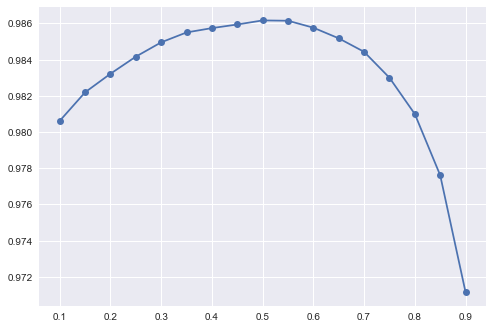

0.5000000000000001


In [112]:
fig , ax=plt.subplots(1,1)
ax.plot(weights,Scores, '-o')
plt.show()
print(weights[np.argmax(Scores)])


# Logistic Regression 

In [8]:
def plot_ROC(FP, TP):
    TP.append(1)
    FP.append(1)
    fig, ax=plt.subplots(1,1)
    ax.plot(FP,TP)
    ax.plot([0,1],[0,1], 'k--')
    plt.show()
def compute_AUC(FP,TP):
    s=0
    for i in range(0,len(FP)-1):
        width=FP[i+1]-FP[i]
        height=(TP[i+1]+TP[i])/2
        s=s+width*height
    return s
def create_weights():
    Interval1=np.arange(0.1,0.91,0.2)
    Interval2=np.arange(0.91,0.991,0.02)
    Interval3=np.arange(0.991,0.9991,0.002)
    weights=np.concatenate((Interval1,Interval2,Interval3))
    return weights
def determine_best_weight(TP,FP, weights):
    diff=np.asarray(TP)-np.asarray(FP)
    return weights[np.argmax(diff)]
def logit_ROC(X, Y):
    TP,FP=[0],[0]
    weights=create_weights()
    for w in weights:
        logreg = linear_model.LogisticRegression(C=1e5, fit_intercept=True, class_weight={1:w, 0:(1-w)})
        logreg.fit(X, Y)
        pred=logreg.predict(X)
        tn, fp, fn, tp=confusion_matrix(Y, pred).ravel()
        TP.append(tp/(tp+fn))
        FP.append(fp/(fp+tn))
    plot_ROC(FP, TP)
    print('best weight=%f'%determine_best_weight(TP,FP, weights))
    return (FP, TP)

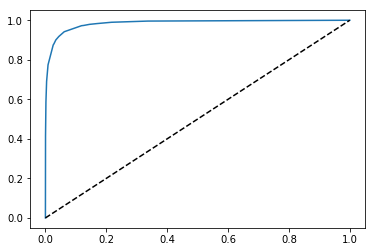

best weight=0.990000
AUC for the training data=0.984454


In [9]:

fp,tp=logit_ROC(X_train,Y_train)
print('AUC for the training data=%f'%compute_AUC(fp,tp))

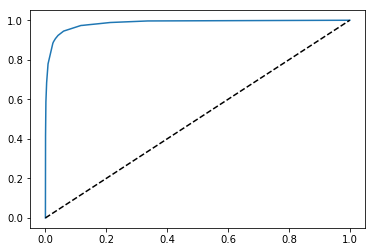

best weight=0.990000
AUC for the test data=0.985210


In [10]:
X_test=test_dummy.iloc[:,test_dummy.columns!='converted']
Y_test=test_dummy['converted']
fp,tp=logit_ROC(X_test,Y_test)
print('AUC for the test data=%f'%compute_AUC(fp,tp))

#the AUC for test and train data are close. the best weights are equal for both test and training data, which is good

# Random Forest 

In [15]:
#X=train[['country', 'new_user','age','total_pages_visited', 'source']]
#Y=train['converted'] 
#xtest=test[['country', 'new_user','age','total_pages_visited', 'source']]
#ytest=test['converted'] 

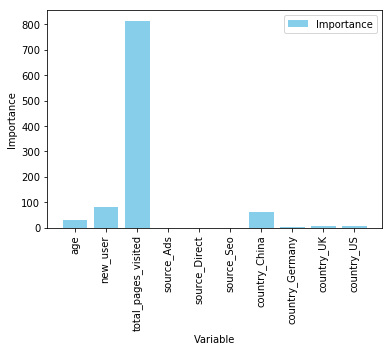

                            imp
age                   30.577719
new_user              80.018284
total_pages_visited  815.137844
source_Ads             0.096858
source_Direct          0.258513
source_Seo             0.044110
country_China         62.255634
country_Germany        1.484879
country_UK             5.166886
country_US             4.959272


In [16]:

print ("error=", 1-clf.oob_score_)
print(1-clf.score(xtest, ytest))

error= 0.01530861516747195
0.014577197926892382


In [17]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [18]:
params = {'n_estimators': 100, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = GradientBoostingClassifier(**params)
clf.fit(X, Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=3, subsample=0.5, verbose=0,
              warm_start=False)

In [19]:
print(clf.feature_importances_)
print(X.columns)


[0.04280038 0.0387041  0.00840744 0.91008808 0.        ]
Index(['country', 'new_user', 'age', 'total_pages_visited', 'source'], dtype='object')


In [24]:
#pdp, axes = partial_dependence(clf,[0,1],X=X, grid_resolution=50)

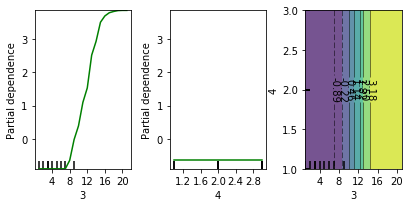

In [35]:
features = [ 3,4, (3, 4)]
fig, axs = plot_partial_dependence(clf, X, features, label=1)
plt.show()

In [11]:
clf1 = DecisionTreeClassifier(max_depth=3)
clf1 = clf1.fit(X, Y)

In [12]:
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

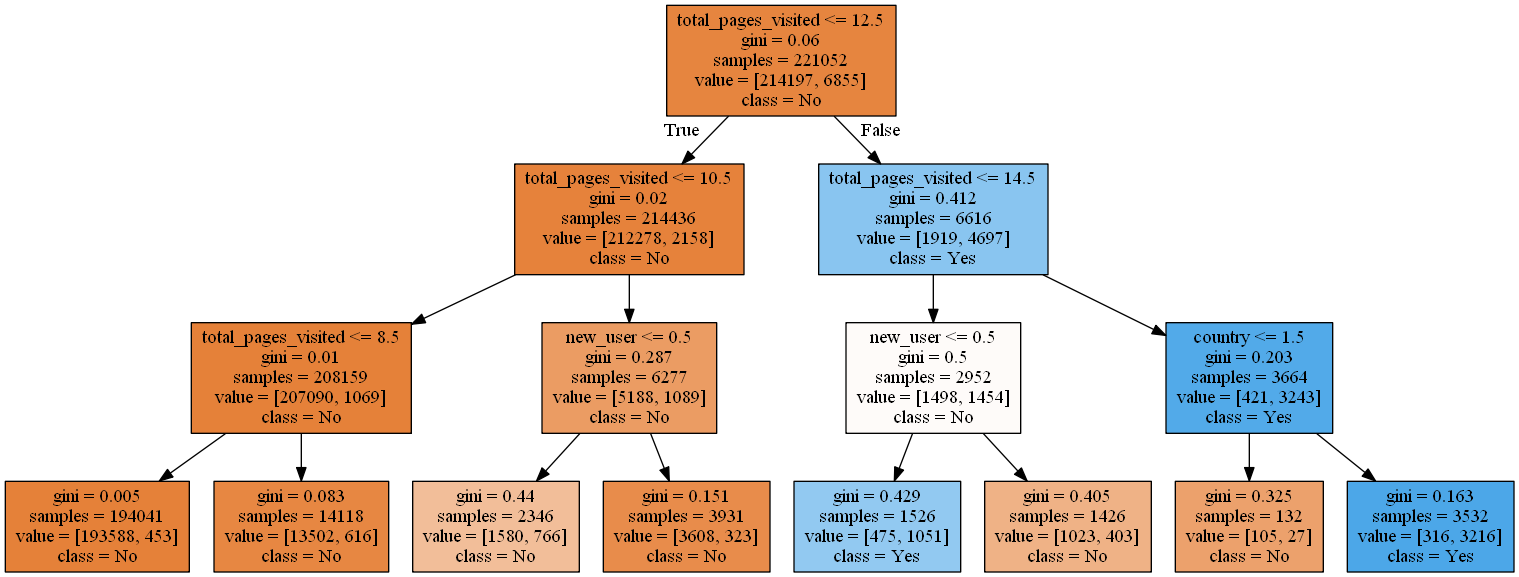

In [13]:
graph3, = print_tree(clf1, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

In [ ]:
print(clf1.feature_importances_)
print(clf1.tree_)

In [41]:
from sklearn import metrics
true_labels=Y
pred=clf1.predict_proba(X)[:,0]

fpr, tpr, thresholds = metrics.roc_curve(Y, pred, pos_label=0)

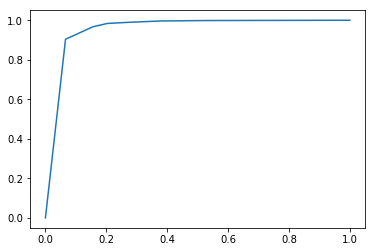

In [42]:
fig, ax=plt.subplots(1,1)
ax.plot(fpr,tpr)
plt.show()